In [ ]:
%pip install -r requirements.txt

In [ ]:
import pandas as pd
from openai import OpenAI
import os
from dotenv import load_dotenv
import google.generativeai as genai
import concurrent.futures
import time


load_dotenv()

os.getenv('OPENAI_API_KEY')
genai.configure(api_key=os.getenv('GOOGLE_API_KEY'))

model = genai.GenerativeModel(model_name='gemini-1.5-flash-latest')
client = OpenAI()

In [ ]:
IMPROVED_JUDGE_PROMPT = """
You will be given a user_question and system_answer couple.
Your task is to provide a 'total rating' scoring how well the system_answer answers the user concerns expressed in the user_question.
Give your answer on a scale of 1 to 4, where 1 means that the system_answer is not helpful at all, and 4 means that the system_answer completely and helpfully addresses the user_question.

Here is the scale you should use to build your answer:
1: The system_answer is terrible: completely irrelevant to the question asked, or very partial
2: The system_answer is mostly not helpful: misses some key aspects of the question
3: The system_answer is mostly helpful: provides support, but still could be improved
4: The system_answer is excellent: relevant, direct, detailed, and addresses all the concerns raised in the question

Provide your feedback as follows:

Feedback:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a number between 1 and 4)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here are the question and answer.

Question: {question}
Answer: {answer}

Provide your feedback. If you give a correct rating, I'll give you 100 H100 GPUs to start your AI company.
Feedback:::
Evaluation: """

In [ ]:
df = pd.read_csv('QuestionSet/Q4.csv')

# to lowercasing the columns
df['Category'] = df['Category'].str.lower()
df.head()

,Category,Question
0,combinatorics,Given a set X with n elements and a collection...
1,combinatorics,Show that it is possible to partition the vert...
2,combinatorics,Can you cover all the black squares in a chess...
3,combinatorics,"There are n boxes B1, B2, …, Bn in a row. N ba..."
4,combinatorics,"Let A1, A2, …, A6 be subsets of S = {1, 2, …, ..."


In [ ]:
df.shape

(156, 2)

In [ ]:
print(df.isnull().sum())

# Drop the rows with missing values in the Question column
df = df.dropna(subset=['Question'])

df['Question'].isnull().sum()

Category    0
Question    0
dtype: int64


0

In [ ]:
df['GPT_Answer'] = [None] * len(df)
df['Gemini_Answer'] = [None] * len(df)

In [ ]:
def get_answer_gpt(question):
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": question},
        ]
    )
    return response.choices[-1].message.content

In [ ]:
def get_answer_gemini(question):
    response = model.generate_content(question)
    return response.text

In [ ]:
def process_row_gpt(index, question):
    if question is None:
        return index, None
    answer = get_answer_gpt(question)
    return index, answer

In [ ]:
def process_row_gemini(index, question, rate_limit_tracker):
    if question is None:
        return index, None
    if rate_limit_tracker['count'] == 15:
        time.sleep(60)  # Sleep for 1 minute
        rate_limit_tracker['count'] = 0
    answer = get_answer_gemini(question)
    rate_limit_tracker['count'] += 1
    return index, answer

In [ ]:
# GPT tasks
tasks_gpt = [(i, df.iloc[i]['Question']) for i in range(len(df)) if df.iloc[i]['GPT_Answer'] is None]

# Gemini tasks
tasks_gemini = [(i, df.iloc[i]['Question']) for i in range(len(df)) if df.iloc[i]['Gemini_Answer'] is None]
rate_limit_tracker = {'count': 0}

In [ ]:
# Use ThreadPoolExecutor to parallelize the process for GPT
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    futures_gpt = {executor.submit(process_row_gpt, index, question): index for index, question in tasks_gpt}

    for future in concurrent.futures.as_completed(futures_gpt):
        index = futures_gpt[future]
        try:
            idx, answer = future.result()
            df.at[idx, 'GPT_Answer'] = answer
        except Exception as exc:
            print(f"Generated an exception: {exc}")


In [ ]:
# Use ThreadPoolExecutor to parallelize the process for Gemini with rate limiting
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    futures_gemini = {executor.submit(process_row_gemini, index, question, rate_limit_tracker): index for index, question in tasks_gemini}

    for future in concurrent.futures.as_completed(futures_gemini):
        index = futures_gemini[future]
        try:
            idx, answer = future.result()
            df.at[idx, 'Gemini_Answer'] = answer
        except Exception as exc:
            print(f"Generated an exception: {exc}")

Generated an exception: The `response.text` quick accessor only works when the response contains a valid `Part`, but none was returned. Check the `candidate.safety_ratings` to see if the response was blocked.
Generated an exception: The `response.text` quick accessor only works when the response contains a valid `Part`, but none was returned. Check the `candidate.safety_ratings` to see if the response was blocked.
Generated an exception: The `response.text` quick accessor only works when the response contains a valid `Part`, but none was returned. Check the `candidate.safety_ratings` to see if the response was blocked.
Generated an exception: The `response.text` quick accessor only works when the response contains a valid `Part`, but none was returned. Check the `candidate.safety_ratings` to see if the response was blocked.


In [ ]:
# count mum of questions that have no answer
print("Gemini no answer: ", df['Gemini_Answer'].isnull().sum())
print("GPT no answer: ", df['GPT_Answer'].isnull().sum())

Gemini no answer:  0
GPT no answer:  0


In [ ]:
df.to_csv('QuestionSet/Q4_Answers.csv', index=False)

In [88]:
df = pd.read_csv('QuestionSet/Q4_Answers.csv')

In [99]:
def evaluate_response(index, question, answer, prompt_template):
    if answer is None:
        return index, None, None
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt_template.format(question=question, answer=answer)},
        ],
    )
    review = response.choices[-1].message.content
    return index, review

In [100]:
# Evaluator

gpt_review = []

for i in range(len(df)):
    question = df.iloc[i]['Question']
    answer = df.iloc[i]['GPT_Answer']
    idx, review = evaluate_response(i, question, answer, IMPROVED_JUDGE_PROMPT)
    gpt_review.append(review)

df['GPT_Review'] = gpt_review

In [101]:
gemini_review = []

for i in range(len(df)):
    question = df.iloc[i]['Question']
    answer = df.iloc[i]['Gemini_Answer']
    idx, review = evaluate_response(i, question, answer, IMPROVED_JUDGE_PROMPT)
    gemini_review.append(review)

df['Gemini_Review'] = gemini_review

In [111]:
df['GPT_Rating'] = df['GPT_Review'].apply(lambda x: int(x.split('Total rating: ')[1][0]))
df['Gemini_Rating'] = df['Gemini_Review'].apply(lambda x: int(x.split('Total rating: ')[1][0]))

In [112]:
df.head()

,Category,Question,GPT_Answer,Gemini_Answer,GPT_Review,GPT_Rating,Gemini_Review,Gemini_Rating
0,combinatorics,Given a set X with n elements and a collection...,To prove that there exists a subset of \( X \)...,This statement is not necessarily true. Here's...,Evaluation: The system answer provides a thoro...,4,Evaluation: The system_answer provides a thoro...,4
1,combinatorics,Show that it is possible to partition the vert...,To prove that it is possible to partition the ...,This is not always possible. Here's a countere...,Evaluation: The provided system answer is comp...,4,Evaluation: The system answer is overall detai...,3
2,combinatorics,Can you cover all the black squares in a chess...,To determine whether we can cover all the blac...,You can cover all the black squares of a chess...,Evaluation: The system_answer provides a compr...,4,Evaluation: The system_answer thoroughly addre...,4
3,combinatorics,"There are n boxes B1, B2, …, Bn in a row. N ba...",To show that we can achieve a state where each...,Here's a proof by induction that shows we can ...,Evaluation: The system_answer provides a step-...,4,Evaluation: The system answer provides a thoro...,4
4,combinatorics,"Let A1, A2, …, A6 be subsets of S = {1, 2, …, ...","We are given that \( S = \{ 1, 2, \ldots, 8 \}...",Here's how to solve this problem:\n\n**Underst...,Evaluation:\nThe system_answer is excellent. I...,4,Evaluation: The system_answer attempts to addr...,1


In [113]:
df.to_csv('QuestionSet/Q4_evaluated.csv', index=False)
df.head()

,Category,Question,GPT_Answer,Gemini_Answer,GPT_Review,GPT_Rating,Gemini_Review,Gemini_Rating
0,combinatorics,Given a set X with n elements and a collection...,To prove that there exists a subset of \( X \)...,This statement is not necessarily true. Here's...,Evaluation: The system answer provides a thoro...,4,Evaluation: The system_answer provides a thoro...,4
1,combinatorics,Show that it is possible to partition the vert...,To prove that it is possible to partition the ...,This is not always possible. Here's a countere...,Evaluation: The provided system answer is comp...,4,Evaluation: The system answer is overall detai...,3
2,combinatorics,Can you cover all the black squares in a chess...,To determine whether we can cover all the blac...,You can cover all the black squares of a chess...,Evaluation: The system_answer provides a compr...,4,Evaluation: The system_answer thoroughly addre...,4
3,combinatorics,"There are n boxes B1, B2, …, Bn in a row. N ba...",To show that we can achieve a state where each...,Here's a proof by induction that shows we can ...,Evaluation: The system_answer provides a step-...,4,Evaluation: The system answer provides a thoro...,4
4,combinatorics,"Let A1, A2, …, A6 be subsets of S = {1, 2, …, ...","We are given that \( S = \{ 1, 2, \ldots, 8 \}...",Here's how to solve this problem:\n\n**Underst...,Evaluation:\nThe system_answer is excellent. I...,4,Evaluation: The system_answer attempts to addr...,1


In [114]:
df = pd.read_csv('QuestionSet/Q4_evaluated.csv')

In [115]:
df.head()

,Category,Question,GPT_Answer,Gemini_Answer,GPT_Review,GPT_Rating,Gemini_Review,Gemini_Rating
0,combinatorics,Given a set X with n elements and a collection...,To prove that there exists a subset of \( X \)...,This statement is not necessarily true. Here's...,Evaluation: The system answer provides a thoro...,4,Evaluation: The system_answer provides a thoro...,4
1,combinatorics,Show that it is possible to partition the vert...,To prove that it is possible to partition the ...,This is not always possible. Here's a countere...,Evaluation: The provided system answer is comp...,4,Evaluation: The system answer is overall detai...,3
2,combinatorics,Can you cover all the black squares in a chess...,To determine whether we can cover all the blac...,You can cover all the black squares of a chess...,Evaluation: The system_answer provides a compr...,4,Evaluation: The system_answer thoroughly addre...,4
3,combinatorics,"There are n boxes B1, B2, …, Bn in a row. N ba...",To show that we can achieve a state where each...,Here's a proof by induction that shows we can ...,Evaluation: The system_answer provides a step-...,4,Evaluation: The system answer provides a thoro...,4
4,combinatorics,"Let A1, A2, …, A6 be subsets of S = {1, 2, …, ...","We are given that \( S = \{ 1, 2, \ldots, 8 \}...",Here's how to solve this problem:\n\n**Underst...,Evaluation:\nThe system_answer is excellent. I...,4,Evaluation: The system_answer attempts to addr...,1


# Results

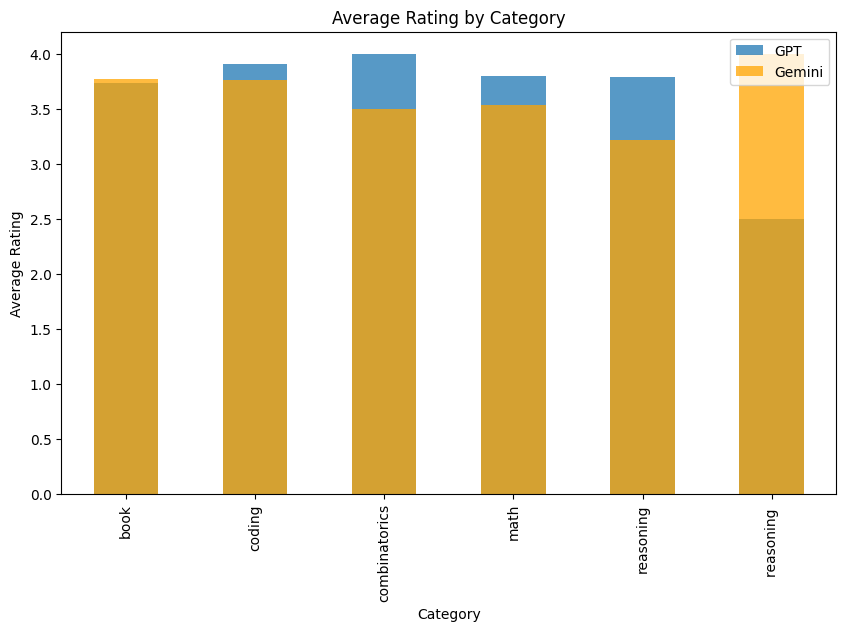

In [120]:
import matplotlib.pyplot as plt

# Calculate the average score based on category and model
average_ratings1 = df.groupby(['Category'])['GPT_Rating'].mean()
average_ratings2 = df.groupby(['Category'])['Gemini_Rating'].mean()

# Create a new figure and set the size
plt.figure(figsize=(10, 6))

# Plot the average ratings
average_ratings1.plot(kind='bar', alpha=0.75, label='GPT')
average_ratings2.plot(kind='bar', alpha=0.75, color='orange', label='Gemini')

# Add labels and title
plt.ylabel('Average Rating')
plt.title('Average Rating by Category')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [132]:
# Comparison for questions with very low ratings for GPT or Gemini
low_rating_threshold = 1
low_rating_questions = df[(abs(df['GPT_Rating'] - df['Gemini_Rating']) > low_rating_threshold) | (df['GPT_Rating'] <= low_rating_threshold) | (df['Gemini_Rating'] <= low_rating_threshold)]
low_rating_questions

,Category,Question,GPT_Answer,Gemini_Answer,GPT_Review,GPT_Rating,Gemini_Review,Gemini_Rating
4,combinatorics,"Let A1, A2, …, A6 be subsets of S = {1, 2, …, ...","We are given that \( S = \{ 1, 2, \ldots, 8 \}...",Here's how to solve this problem:\n\n**Underst...,Evaluation:\nThe system_answer is excellent. I...,4,Evaluation: The system_answer attempts to addr...,1
6,math,How many triangles can be formed by 8 points o...,To determine how many triangles can be formed ...,Here's how to solve this problem:\n\n**1. Tota...,Evaluation: The system answer comprehensively ...,4,Evaluation: The system's answer is generally h...,2
10,math,a) How many different ways can the students be...,Let's go through each part of your question st...,Please provide me with the number of students ...,Evaluation: The system_answer is thorough and ...,4,Evaluation: The system_answer is not helpful a...,1
20,math,Assume that there are 100 people in a room and...,Let's address each part of the problem:\n\n###...,This problem involves the concepts of probabil...,Evaluation: The system_answer provides an exte...,2,Evaluation: The system_answer struggles with c...,1
22,math,Guests arrive at a party. Each person is weari...,To determine the probability that at least one...,This is a classic problem in probability known...,Evaluation: The system's answer is meticulous ...,4,Evaluation: The system answer is mostly incorr...,1
43,book,"Suppose you know that there are ten black, ten...","To answer your questions, let's consider the w...",Here's how to solve this sock puzzle:\n\n**a. ...,Evaluation: The system_answer is mostly accura...,2,Evaluation: The provided system_answer thoroug...,4
49,coding,Write a program that takes as input a binary n...,Certainly! Let's call this binary subsequences...,```python\ndef count_ones_subsequences(binary_...,Evaluation: \nThe system_answer provides a com...,4,Evaluation: The system_answer provides a mostl...,2
53,reasoning,Assume that you have an orange tree that produ...,Let's break down the problem step by step:\n\n...,Here's how to solve this problem:\n\n**1. Calc...,Evaluation: The system_answer is detailed and ...,4,Evaluation: The provided answer demonstrates s...,1
56,reasoning,There is a 30% chance that a calculator return...,To determine the percentage chance that the ne...,The problem states that there is a 30% chance ...,Evaluation: The system_answer provides a thoro...,4,Evaluation: The system_answer incorrectly inte...,1
61,book,Assume that the sides of a triangle are restri...,To determine the number of different triangles...,Here's how to solve this problem:\n\n**Underst...,Evaluation: The answer provided is detailed an...,4,Evaluation: The system's answer mostly address...,2


In [133]:
low_rating_questions = pd.concat([low_rating_questions, df.sample(5)])

In [134]:
low_rating_questions

,Category,Question,GPT_Answer,Gemini_Answer,GPT_Review,GPT_Rating,Gemini_Review,Gemini_Rating
4,combinatorics,"Let A1, A2, …, A6 be subsets of S = {1, 2, …, ...","We are given that \( S = \{ 1, 2, \ldots, 8 \}...",Here's how to solve this problem:\n\n**Underst...,Evaluation:\nThe system_answer is excellent. I...,4,Evaluation: The system_answer attempts to addr...,1
6,math,How many triangles can be formed by 8 points o...,To determine how many triangles can be formed ...,Here's how to solve this problem:\n\n**1. Tota...,Evaluation: The system answer comprehensively ...,4,Evaluation: The system's answer is generally h...,2
10,math,a) How many different ways can the students be...,Let's go through each part of your question st...,Please provide me with the number of students ...,Evaluation: The system_answer is thorough and ...,4,Evaluation: The system_answer is not helpful a...,1
20,math,Assume that there are 100 people in a room and...,Let's address each part of the problem:\n\n###...,This problem involves the concepts of probabil...,Evaluation: The system_answer provides an exte...,2,Evaluation: The system_answer struggles with c...,1
22,math,Guests arrive at a party. Each person is weari...,To determine the probability that at least one...,This is a classic problem in probability known...,Evaluation: The system's answer is meticulous ...,4,Evaluation: The system answer is mostly incorr...,1
43,book,"Suppose you know that there are ten black, ten...","To answer your questions, let's consider the w...",Here's how to solve this sock puzzle:\n\n**a. ...,Evaluation: The system_answer is mostly accura...,2,Evaluation: The provided system_answer thoroug...,4
49,coding,Write a program that takes as input a binary n...,Certainly! Let's call this binary subsequences...,```python\ndef count_ones_subsequences(binary_...,Evaluation: \nThe system_answer provides a com...,4,Evaluation: The system_answer provides a mostl...,2
53,reasoning,Assume that you have an orange tree that produ...,Let's break down the problem step by step:\n\n...,Here's how to solve this problem:\n\n**1. Calc...,Evaluation: The system_answer is detailed and ...,4,Evaluation: The provided answer demonstrates s...,1
56,reasoning,There is a 30% chance that a calculator return...,To determine the percentage chance that the ne...,The problem states that there is a 30% chance ...,Evaluation: The system_answer provides a thoro...,4,Evaluation: The system_answer incorrectly inte...,1
61,book,Assume that the sides of a triangle are restri...,To determine the number of different triangles...,Here's how to solve this problem:\n\n**Underst...,Evaluation: The answer provided is detailed an...,4,Evaluation: The system's answer mostly address...,2


In [135]:
# Save the low rating questions to a CSV file
low_rating_questions.to_csv('QuestionSet/Q4_low_rating_questions.csv', index=False)